In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm import tqdm
import sklearn.metrics as m
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from warnings import filterwarnings
filterwarnings('ignore')

#### universalBank 데이터를 Train set과 Test set으로 나눈후 이용하시오. (ID 제외)

- 0. 데이터를 불러오고, 표준화 척도로 바꿔준 후, 다중공선성 문제를 해결하고 Train set과 Test set을 나누기.

In [2]:
# 데이터 불러오기.
df     = pd.read_csv('data/universalBank.csv')
df.drop( columns=['ID'],inplace=True)
X_data = df.iloc[:,:-1]
x_data = StandardScaler().fit_transform( X_data )     
x_data = pd.DataFrame( x_data, columns=X_data.columns )
y_data = df.iloc[:,-1]

# 다중공선성 확인 전 회귀분석을 통해 유의미한 Feature 찾아보기. => 공선성 문제가 있다면 잘못된 결과일 가능성이 존재.
print('< Criterion >')
print('-'*28)
print( f' AIC   : {round(sm.OLS( y_data, sm.add_constant( x_data ) ).fit().aic, 3)}' )
print( f' adjR2 : {round(sm.OLS( y_data, sm.add_constant( x_data ) ).fit().rsquared_adj, 3)}' )
print('-'*28)
print('< P-value >')
print('-'*28)
print( round(sm.OLS( y_data, sm.add_constant( x_data ) ).fit().pvalues[1:], 3) )

< Criterion >
----------------------------
 AIC   : 5805.72
 adjR2 : 0.102
----------------------------
< P-value >
----------------------------
Age                  0.845
Experience           0.815
Income               0.822
ZIPCode              0.880
Family               0.275
CCAvg                0.348
Education            0.635
Mortgage             0.064
PersonalLoan         0.000
SecuritiesAccount    0.000
CDAccount            0.000
Online               0.000
dtype: float64


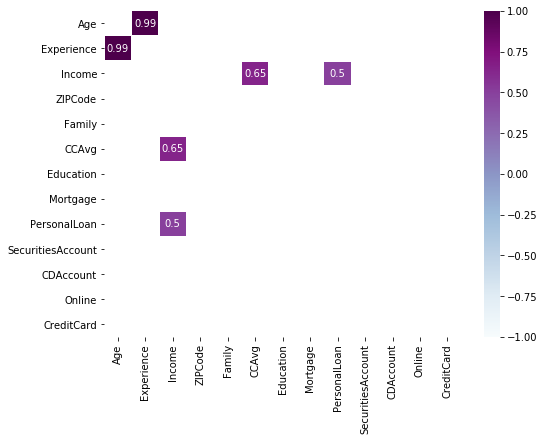

In [3]:
# Hitmap
# Age - Experience, Income - CCAvg 사이에서 높은 상관관계를 지니고 있음을 알수 있음. ==> 다중공선성 문제 발생 추측.
plt.figure( figsize=(8,6) )
sb.heatmap( df.corr()[abs(df.corr()>0.5) & (df.corr() != 1)], vmin=-1, vmax=1, 
           annot=True, linewidths=0.2, cmap='BuPu' ) ; plt.show()

In [4]:
# Age - Experience 사이에서 VIF 값이 높은 것을 알 수 있음. ==> 가장 높은 Age feature data를 제거할 필요가 있음.
VIF             = pd.DataFrame()
VIF['VIF']      = [ variance_inflation_factor( x_data.values, i ) for i in range( x_data.shape[1] ) ]
VIF['features'] = x_data.columns
VIF

,VIF,features
0,93.756251,Age
1,93.671067,Experience
2,2.218811,Income
3,1.002655,ZIPCode
4,1.061295,Family
5,1.736928,CCAvg
6,1.199184,Education
7,1.051450,Mortgage
8,1.617776,PersonalLoan
9,1.125268,SecuritiesAccount


In [5]:
# 가장 높은 Age feature data 제거 결과 VIF 값이 안정화 ==> 다중공선성 문제는 해결됨.
x_data           = x_data[ x_data.columns.difference(['Age']) ]
VIF2             = pd.DataFrame()
VIF2['VIF']      = [ variance_inflation_factor( x_data.values, i ) for i in range( x_data.shape[1] ) ]
VIF2['features'] = x_data.columns
VIF2

,VIF,features
0,1.731984,CCAvg
1,1.296452,CDAccount
2,1.122766,Education
3,1.008847,Experience
4,1.059672,Family
5,2.216098,Income
6,1.051449,Mortgage
7,1.039079,Online
8,1.616408,PersonalLoan
9,1.125003,SecuritiesAccount


In [6]:
# 그러나 Feature data가 target data와 그다지 상관관계가 높지도 않을 뿐더러, 유의미한 Feature도 많다고 보기 어려움.
# 수정된 결정계수나, AIC 등 기타 기준도 매우 안좋음을 확인할 수 있음. => 즉 이 특성 데이터로는 잘 학슴될 것 같지 않음.
print('< Criterion >')
print('-'*28)
print( f' AIC   : {round(sm.OLS( y_data, sm.add_constant( x_data ) ).fit().aic, 3)}' )
print( f' adjR2 : {round(sm.OLS( y_data, sm.add_constant( x_data ) ).fit().rsquared_adj, 3)}' )
print('-'*28)
print('< p-value >')
print('-'*28)
print( round(sm.OLS( y_data,  sm.add_constant( x_data ) ).fit().pvalues[1:], 3) )

< Criterion >
----------------------------
 AIC   : 5803.758
 adjR2 : 0.102
----------------------------
< p-value >
----------------------------
CCAvg                0.342
CDAccount            0.000
Education            0.588
Experience           0.703
Family               0.278
Income               0.817
Mortgage             0.064
Online               0.000
PersonalLoan         0.000
SecuritiesAccount    0.000
ZIPCode              0.880
dtype: float64


In [7]:
# Split Train data : Test data : 75% : 25%
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, stratify=y_data)

- 1. 나이브 베이즈, SVM 을 이용하여 최적파라미터찾고, F1 Score, ROC 검정하기.

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [06:46<00:00, 203.47s/it]

- Accuracy of Naïve Bayes model -
----------------------------------------------------------------------------------------------------------------------------------
Best Parameter                 : <bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('bernoullinb',
                 BernoulliNB(alpha=0.0, binarize=0.0, class_prior=None,
                             fit_prior=True))],
         verbose=False)>
Accuracy of train data         : 74.0%
Accuracy of test data          : 74.0%
----------------------------------------------------------------------------------------------------------------------------------
- F1 score of Naïve Bayes model -
----------------------------------------------------------------------------------------------------------------------------------
F1 score of train data        : 27.0%
F1 score of test data         : 26.0%
-----

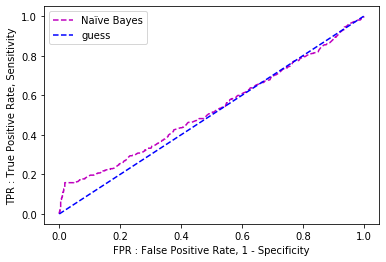

----------------------------------------------------------------------------------------------------------------------------------
- Accuracy of SVM model -
----------------------------------------------------------------------------------------------------------------------------------
Best Parameter                 : <bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)>
Accuracy of train data         : 75.0%
Accuracy of test data          : 74.0%
-------------------------------------------

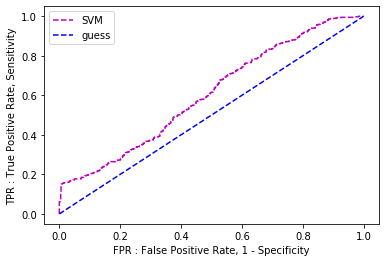

In [8]:
# 위 두 분류기는 어째서인지 pipeline을 쓰지 않고, 돌아가지 않기 때문에 위 0번에서 미리 표준화를 해줌.

# GridSearch 를 통해 두 모형의 최적 파라미터를 찾고, best_model_list로 반환.
# 그 결과 ==> best_model_list[0] : 그리드 서치로 찾은 최적의 나이브 베이즈 모형, 
#         ==> best_model_list[1] : 그리드 서치로 찾은 최적의 서포트 벡터 머신 모형.

Classifiers    = []
Parameters     = []

Bnb            = make_pipeline(StandardScaler(), BernoulliNB())
SVM            = make_pipeline(StandardScaler(), SVC(probability=True))  
                                                # SVC에서 확률값을 True로 해야. predict, predict_proba 사용 가능.

Parameters_SVM = { 'svc__C': list(range(0,11)),
                   'svc__gamma':  ['scale'],
                   'svc__kernel' :['linear', 'poly', 'rbf', 'sigmoid', 'precomputed' ]
                 }
Parameters_Bnb = {'bernoullinb__alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0] }

Classifiers.append( Bnb )
Classifiers.append( SVM )

Parameters.append( Parameters_Bnb )
Parameters.append( Parameters_SVM )

def gridSearchCV( models, params, count ):
    best_models=[]
    for i in tqdm(range( 0, count )):
        model_grid = GridSearchCV( models[i], Parameters[i] )
        model_grid.fit( x_train, y_train )
        best_models.append( model_grid.best_estimator_ )
    return best_models

best_model_list = gridSearchCV( Classifiers, Parameters, 2 )

# -----------------------------------------------------------------------------------------------------

# Accuracy of Naïve Bayes model.
print('- Accuracy of Naïve Bayes model -')
print('-'*130)
print(f'Best Parameter                 : { best_model_list[0].get_params}')
print(f'Accuracy of train data         : {round( best_model_list[0].score( x_train, y_train ), 2)*100 }%')
print(f'Accuracy of test data          : {round( best_model_list[0].score( x_test, y_test ),   2)*100 }%')
print('-'*130)

# Prediction of Naïve Bayes model.
y_pred_train0  = best_model_list[0].predict( x_train )
y_pred_test0   = best_model_list[0].predict( x_test )

# F1 score of Naïve Bayes model.
print('- F1 score of Naïve Bayes model -')
print('-'*130)
print(f'F1 score of train data        : { round(m.f1_score( y_train, y_pred_train0  ), 2)*100       }%' )
print(f'F1 score of test data         : { round(m.f1_score( y_test,   y_pred_test0  ), 2)*100       }%' )
print('-'*130)

# ROC Curve
print('- ROC Curve of Naïve Bayes model -')
print('-'*130)
FPR, TPR, Thresholds = m.roc_curve( y_test, best_model_list[0].predict_proba( x_test )[:,1] )    
plt.plot( FPR, TPR, 'm--', label='Naïve Bayes')
plt.plot( [0,1], [0,1], 'b--', label='guess' )
plt.xlabel( 'FPR : False Positive Rate, 1 - Specificity' ); plt.ylabel( 'TPR : True Positive Rate, Sensitivity' )
plt.legend()
plt.show()
print('-'*130)

# -----------------------------------------------------------------------------------------------------

# Accuracy of SVM model.
print('- Accuracy of SVM model -')
print('-'*130)
print(f'Best Parameter                 : { best_model_list[1].get_params}')
print(f'Accuracy of train data         : {round( best_model_list[1].score( x_train, y_train ), 2)*100 }%')
print(f'Accuracy of test data          : {round( best_model_list[1].score( x_test, y_test ),   2)*100 }%')
print('-'*130)

# Prediction of SVM model.
y_pred_train1  = best_model_list[1].predict( x_train )
y_pred_test1   = best_model_list[1].predict( x_test )

# F1 score of SVM modell.
print('- F1 score of SVM model -')
print('-'*130)
print(f'F1 score of train data        : { round(m.f1_score( y_train, y_pred_train1  ), 2)*100       }%' )
print(f'F1 score of test data         : { round(m.f1_score( y_test,   y_pred_test1  ), 2)*100       }%' )
print('-'*130)


# ROC Curve
print('- ROC Curve of SVM model -')
print('-'*130)
FPR, TPR, Thresholds = m.roc_curve( y_test, best_model_list[1].predict_proba( x_test )[:,1] )    
plt.plot( FPR, TPR, 'm--', label='SVM')
plt.plot( [0,1], [0,1], 'b--', label='guess' )
plt.xlabel( 'FPR : False Positive Rate, 1 - Specificity' ); plt.ylabel( 'TPR : True Positive Rate, Sensitivity' )
plt.legend()
plt.show()

- 2. 위 2개 모델을 Voting으로 구하고, F1 Score, ROC 검정하시오.

- Accuracy of Voting -
----------------------------------------------------------------------------------------------------------------------------------
Accuracy of train data         : 74.0%
Accuracy of test data          : 74.0%
----------------------------------------------------------------------------------------------------------------------------------
- F1 score of Voting model -
----------------------------------------------------------------------------------------------------------------------------------
F1 score of train data        : 27.0%
F1 score of test data         : 26.0%
----------------------------------------------------------------------------------------------------------------------------------
- ROC Curve of Voting model -
----------------------------------------------------------------------------------------------------------------------------------


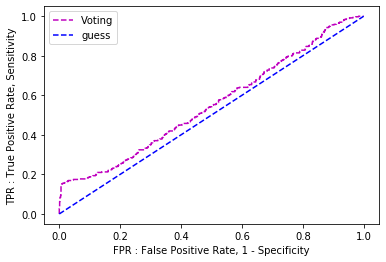

In [9]:
# `위 1번에서 그리드 서치로 찾아 최적의 파라미터를 반환한 best_model_list에 있는 두 모형을 Voting 시킴.
# Voting model.
model_vote = VotingClassifier( estimators=[('Naïve Bayes', best_model_list[0]), 
                                           ('SVM', best_model_list[1])], voting='soft'  )
model_vote.fit( x_train, y_train )


# Accuracy of voting.
print('- Accuracy of Voting -')
print('-'*130)
print(f'Accuracy of train data         : {round( model_vote.score( x_train, y_train ), 2)*100 }%')
print(f'Accuracy of test data          : {round( model_vote.score( x_test, y_test ),   2)*100 }%')
print('-'*130)

# Prediction of Voting model.
y_pred_train  = model_vote.predict( x_train )
y_pred_test   = model_vote.predict( x_test )

# F1 score of  Voting model.
print('- F1 score of Voting model -')
print('-'*130)
print(f'F1 score of train data        : { round(m.f1_score( y_train, y_pred_train  ), 2)*100       }%' )
print(f'F1 score of test data         : { round(m.f1_score( y_test,   y_pred_test  ), 2)*100       }%' )
print('-'*130)

# ROC Curve
print('- ROC Curve of Voting model -')
print('-'*130)
FPR, TPR, Thresholds = m.roc_curve( y_test, model_vote.predict_proba( x_test )[:,1] )    
plt.plot( FPR, TPR, 'm--', label='Voting')
plt.plot( [0,1], [0,1], 'b--', label='guess' )
plt.xlabel( 'FPR : False Positive Rate, 1 - Specificity' ); plt.ylabel( 'TPR : True Positive Rate, Sensitivity' )
plt.legend()
plt.show()

- 3.  다중공선성 높은 컬럼 제거 후 군집분류(2개의 특성데이터)를 하시오.

< Scree plot by K-means >
----------------------------------------------------------------------------------------------------------------------------------


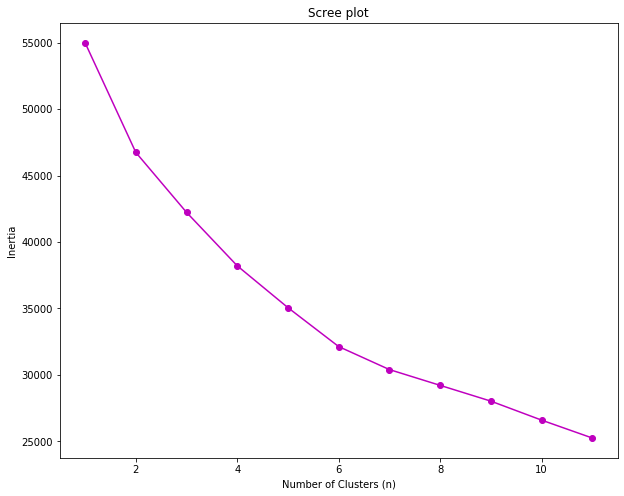

----------------------------------------------------------------------------------------------------------------------------------


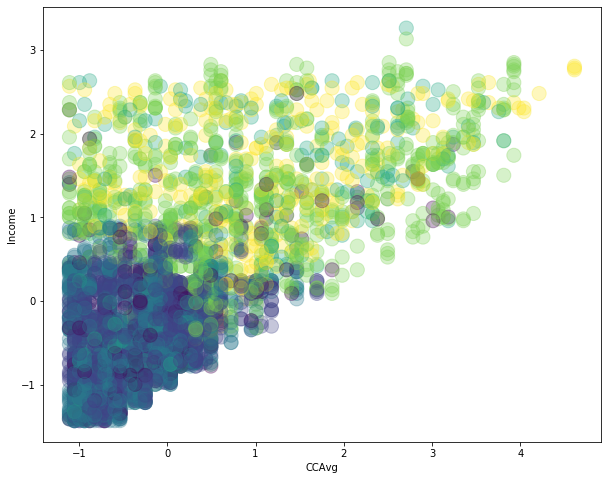

In [10]:
# K-means를 통해 본 군집의 개수 ==> 이 역시 4번의 PCA의 주성분 분산 비율 설명력 정도와 유사한 경향을 가짐.
print('< Scree plot by K-means >')
print('-'*130)
num_clusters = list(range(1, 12))	
inertias     = []

for i in num_clusters:
    k_model = KMeans( n_clusters=i )
    k_model.fit( x_data )
    inertias.append(k_model.inertia_)             
     # k_model.inertia_ : 각 센터를 중심으로 떨어진 거리의 총합값의 평균.

plt.figure(figsize=(10,8))       
plt.plot( num_clusters, inertias, '-mo' )
plt.title('Scree plot')
plt.xlabel('Number of Clusters (n)'); plt.ylabel('Inertia')
plt.show()
print('-'*130)


# 두 특성 데이터 ==> 'CCAvg' & 'Income'
df_k    = pd.concat([x_data, y_data], axis=1)
model_k = KMeans(n_clusters=6)                # scree plot을 토대로 6정도로 설정해 봄.
model_k.fit(df_k)
labels  = model_k.predict(df_k)

x = df_k['CCAvg']
y = df_k['Income']
plt.figure(figsize=(10,8))     
plt.scatter(x, y, c=labels, alpha=0.3, s=200)
plt.xlabel('CCAvg')
plt.ylabel('Income')
plt.show()

- 4. 차원축소 후 학습하고 Test data 0번째 데이터에 대한 분류 예측값을 구하시오.

----------------------------------------------------------------------------------------------------------------------------------
Proportion of varianc : 70.511%


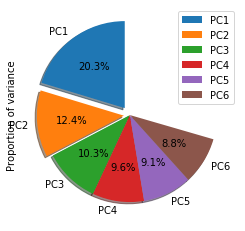

----------------------------------------------------------------------------------------------------------------------------------
- Result of Logit model -
----------------------------------------------------------------------------------------------------------------------------------
Predict of x_test[0]    : 0.0
Accuracy of train data  : 72.0%
Accuracy of test data   : 72.0%


In [11]:
# 위 3번에서 본 스크리 그림을 통해 약 6개 성분으로 설정.
# 주성분수 6개는 약 73% 설명력을 가짐. ==> 11차원에서 6차원으로 차원 축소.

model = PCA( n_components=6 )   
PCA   = model.fit_transform( x_data )
print('-'*130)
print(f'Proportion of varianc : {round(sum( model.explained_variance_ratio_ )*100, 3)}%')
df_ratio = pd.DataFrame( model.explained_variance_ratio_, 
                        index=['PC%i' % i for i in range(1, 7)], columns=['Proportion of variance'] )
df_ratio.plot.pie(y='Proportion of variance', autopct='%1.1f%%',shadow=True, startangle=90, explode=(0.1, 0.07, 0, 0, 0,0))
plt.show()
print('-'*130)

# 차원 축소 후 Logit model에 적합하여 x_test[0] 부분을 예측한 결과 아래와 같음.
x_data_pca  = pd.DataFrame( PCA, columns=['PC%i' % i for i in range(1, 7)] )
x_train, x_test, y_train, y_test = train_test_split(x_data_pca, y_data, test_size = 0.25, stratify=y_data)
model_Logit = LogisticRegression() 
model_Logit.fit( x_train, y_train )

print('- Result of Logit model -')
print('-'*130)
print( f'Predict of x_test[0]    : {float(model_Logit.predict( [x_test.iloc[0]] ))}')
print(f'Accuracy of train data  : {round( model_Logit.score( x_train, y_train ), 2)*100 }%')
print(f'Accuracy of test data   : {round( model_Logit.score( x_test, y_test ),   2)*100 }%')